## COMP5625M Assessment 2 - Image Caption Generation [100 marks]

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

sc21xz

Your full name:

Zhiping Xiang

### Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

Detect which device (CPU/GPU) to use.

In [2]:
# always check your version
print(torch.__version__)
import torch
import math
torch.device('mps')
# True
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('mps' if torch.backends.mps.is_available() else 'cpu')

1.13.1
mps


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [3]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()

        # Load the pretrained ResNet-50 model
        resnet = models.resnet50(pretrained=True)

        # Remove the last fully connected layer of ResNet-50
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        return features


In [4]:
# instantiate encoder and put into evaluation mode.
# Your code here!

# Instantiate the encoder
encoder = EncoderCNN().to(device)

# Put the encoder into evaluation mode
encoder.eval()

/Users/xiangzhiping/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/xiangzhiping/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [5]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [6]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

5068


,file_name
0,000000000009.jpg
1,000000000025.jpg
2,000000000030.jpg
3,000000000034.jpg
4,000000000036.jpg
...,...
5063,000000581906.jpg
5064,000000581909.jpg
5065,000000581913.jpg
5066,000000581921.jpg


In [7]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch 

IMAGE_DIR = "coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        # --> your code here!
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']

        # --> your code here!
        image_path = IMAGE_DIR + filename
        # Load the image
        image = Image.open(image_path).convert("RGB")
        # Apply the transform
        if self.transform is not None:
            image = self.transform(image)
        return image, filename

    def __len__(self):
        return len(self.df)
    

In [8]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
# Your code here-->
# Define the dataset
dataset = COCOImagesDataset(df_unique_files, transform=data_transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [9]:
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this

features_map = dict()
from tqdm.notebook import tqdm
from PIL import Image

with torch.no_grad():
# ---> Your code here!  
# Pass the images through the Encoder model and save the features
    for images, filenames in tqdm(data_loader, desc='Extracting Features'):
        images = images.to(device)
        # Extract features from images
        features = encoder(images)
        # Convert filenames to a list
        filenames = list(filenames)

        # Save the features with the corresponding filenames
        for i in range(len(filenames)):
            filename = filenames[i]
            feature = features[i]
            features_map[filename] = feature
# Save the features dictionary to disk
torch.save(features_map, 'image_features.pt')

Extracting Features:   0%|          | 0/80 [00:00<?, ?it/s]

## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [10]:
import json

# loading captions for training
with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [11]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("coco_subset_meta.csv")
# --> your code here! - name the new dataframe as "new_file"
# Cross-reference coco_subset_meta.csv with the annotations to get the reference captions for COCO_5029
new_file = pd.merge(coco_subset, df,left_on='id',right_on='image_id')
# Select the desired columns in the resulting DataFrame
new_file = new_file[['image_id', 'id_y', 'caption', 'file_name']]
# Rename the 'id_y' column to 'id'
new_file = new_file.rename(columns={'id_y': 'id'})

new_file.head()

,image_id,id,caption,file_name
0,262145,694,People shopping in an open market for vegetables.,000000262145.jpg
1,262145,1054,An open market full of people and piles of veg...,000000262145.jpg
2,262145,1456,People are shopping at an open air produce mar...,000000262145.jpg
3,262145,5248,Large piles of carrots and potatoes at a crowd...,000000262145.jpg
4,262145,5254,People shop for vegetables like carrots and po...,000000262145.jpg


#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [12]:
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):

    # Remove spaces in the beginning and at the end
    # Convert to lower case
    # Replace all non-alphabet characters with space
    # Replace all continuous spaces with a single space

    # -->your code here
    clean_caption = []  # List to store the cleaned captions

    for caption in df['caption']:
        # Remove spaces in the beginning and at the end
        caption = caption.strip()

        # Convert to lowercase
        caption = caption.lower()

        # Replace all non-alphabet characters with space
        caption = ''.join(char if char.isalpha() else ' ' for char in caption)

        # Replace all continuous spaces with a single space
        caption = ' '.join(caption.split())

        # Add the cleaned caption to the list
        clean_caption.append(caption)

    # add to dataframe
    df["clean_caption"] = clean_caption

    return df

In [13]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,id,caption,file_name,clean_caption
0,262145,694,People shopping in an open market for vegetables.,000000262145.jpg,people shopping in an open market for vegetables
1,262145,1054,An open market full of people and piles of veg...,000000262145.jpg,an open market full of people and piles of veg...
2,262145,1456,People are shopping at an open air produce mar...,000000262145.jpg,people are shopping at an open air produce market
3,262145,5248,Large piles of carrots and potatoes at a crowd...,000000262145.jpg,large piles of carrots and potatoes at a crowd...
4,262145,5254,People shop for vegetables like carrots and po...,000000262145.jpg,people shop for vegetables like carrots and po...
5,262145,694,People shopping in an open market for vegetables.,000000262145.jpg,people shopping in an open market for vegetables
6,262145,1054,An open market full of people and piles of veg...,000000262145.jpg,an open market full of people and piles of veg...
7,262145,1456,People are shopping at an open air produce mar...,000000262145.jpg,people are shopping at an open air produce market
8,262145,5248,Large piles of carrots and potatoes at a crowd...,000000262145.jpg,large piles of carrots and potatoes at a crowd...
9,262145,5254,People shop for vegetables like carrots and po...,000000262145.jpg,people shop for vegetables like carrots and po...


#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [14]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [15]:
# Get the unique image IDs from the DataFrame or any other list
unique_image_ids = df['image_id'].unique().tolist()
 # Split the image IDs into train, validation, and test sets
train_ids, valid_ids, test_ids = split_ids(unique_image_ids, train=0.7, valid=0.1, test=0.2)

In [16]:
# Split the data into train/validation/test sets based on the obtained IDs
train_set = new_file[new_file['image_id'].isin(train_ids)]
valid_set = new_file[new_file['image_id'].isin(valid_ids)]
test_set= new_file[new_file['image_id'].isin(test_ids)]
if test_set['image_id'].isin(train_ids).any():
    print("Error: Test set contains training data")
if test_set['image_id'].isin(valid_ids).any():
    print("Error: Test set contains validation data")
if valid_set['image_id'].isin(train_ids).any():
    print("Error: Validation set contains training data")
if valid_set['image_id'].isin(test_ids).any():
    print("Error: Validation set contains test data")
if train_set['image_id'].isin(valid_ids).any():
    print("Error: Training set contains validation data")
if train_set['image_id'].isin(test_ids).any():
    print("Error: Training set contains test data")

print("Train set size: ", len(train_set))
print("Validation set size: ", len(valid_set))
print("Test set size: ", len(test_set))
# test_set.head()

Train set size:  28356
Validation set size:  3939
Test set size:  7718


#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [17]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [18]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'])
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        # --> Your code here!
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)
    return vocab


In [19]:
# build your vocabulary for train, valid and test sets
# ---> your code here!
train_vocab = build_vocab(train_ids, train_set)
valid_vocab = build_vocab(valid_ids, valid_set)
test_vocab = build_vocab(test_ids, test_set)
len(train_vocab), len(valid_vocab), len(test_vocab)

(3152, 973, 1462)

In [20]:
# Create an instance of the Vocabulary object
vocab_ids=train_ids+valid_ids
vocab_dataset=new_file[new_file['image_id'].isin(vocab_ids)]
vocab=build_vocab(vocab_ids,vocab_dataset)
len(vocab)

3395

#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [21]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper

        """
        # TO COMPLETE
        self.df = df
        self.features = {filename: features[filename] for filename in df["file_name"]}
        self.vocab = vocab

    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """
       # TO COMPLETE
       #  print(f"Index: {index}, Total Items: {len(self.df)}")
        # get the filename
        filename = self.df.iloc[index]['file_name']
        # get the image features
        image_features = self.features[filename]
        image_features = image_features.unsqueeze(0)

        # get the caption
        clean_captions = str(self.df.iloc[index]['clean_caption'])
        # convert caption to word ids
        caption_ids = [self.vocab(word) for word in clean_captions.split()]
        # add the <end> token to the end of the caption
        caption_ids.append(self.vocab('<end>'))
        # get the caption length
        caption_length = len(caption_ids)
        # pad the caption to the max sequence length
        while len(caption_ids) < MAX_SEQ_LEN:
            caption_ids.append(self.vocab('<pad>'))

        # Convert the image features and caption IDs to PyTorch Tensors
        image_features = torch.Tensor(image_features)
        caption_ids = torch.Tensor(caption_ids).long().unsqueeze(0)
        # print(f"Image Features: {image_features.shape}, Caption IDs: {caption_ids.shape}, Caption Length:
        # {caption_length}")
        return image_features, caption_ids, caption_length

    def __len__(self):
        return len(self.df)

In [22]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
# --> Your code here
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions,captions_len= zip(*data)
    # print(images)
    # print(captions)
    # print(captions_len)
    images_reshape=tuple()
    for image in images:
    # Merge images: using features, 2D tensor to 3D tensor. (batch_size, 2048)
        image=image.squeeze(0)
        images_reshape+=(image,)
        # print(image.shape)
    # print(images_reshape)
    images=images_reshape
    images = torch.stack(images, dim=0)
    # merge captions (from tuple of 1D tensor to 2D tensor).
    cap_reshape=tuple()
    for cap in captions:
        cap=cap.squeeze(0)
        cap_reshape+=(cap,)
    captions=cap_reshape

    lengths = [len(cap) for cap in captions]
    # print(lengths)
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    targets= targets
    lengths=list(captions_len)
    return images, targets, lengths

In [23]:
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

#  your dataloader here (make shuffle true as you will be training RNN)
# --> your code here!
dataloader_train = DataLoader(
    dataset_train,
    batch_size=64,
    shuffle=True,
    collate_fn=caption_collate_fn
)

# Do the same as above for your validation set
# ---> your code here!
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map
)
dataloader_valid = DataLoader(
    dataset_valid,
    batch_size=64,
    shuffle=False,
    collate_fn=caption_collate_fn
)

Load one batch of the training set and print out the shape of each returned Tensor.

In [24]:
# Load one batch of the training set
images, captions, lengths = next(iter(dataloader_train))
# Print the shape of each returned Tensor
print("Images shape:", images.shape)
print("Captions shape:", captions.shape)
print("Lengths shape:", lengths)

Images shape: torch.Size([64, 2048])
Captions shape: torch.Size([64, 47])
Lengths shape: [10, 34, 10, 11, 9, 12, 13, 9, 9, 15, 15, 11, 10, 11, 12, 14, 11, 10, 11, 9, 10, 11, 9, 12, 9, 11, 9, 9, 11, 9, 10, 11, 12, 13, 17, 9, 12, 10, 14, 12, 10, 12, 10, 9, 13, 11, 14, 10, 12, 9, 11, 12, 11, 11, 8, 10, 12, 9, 13, 13, 11, 20, 11, 26]


## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [45]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize
        # your code
        self.resize = nn.Linear(2048, embed_size)
        # batch normalisation helps to speed up training
        # your code
        self.bn = nn.BatchNorm1d(embed_size)
        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # your code for RNN
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        # self.linear: linear layer with input: hidden layer, output: vocab size
        # --> your code
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length


    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)
        
        # compute your feature embeddings
        # your code
        inputs = torch.cat((im_features.unsqueeze(1), embeddings), dim=1)

    
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed_inputs = nn.utils.rnn.pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        # Forward pass through the RNN layer
        packed_outputs, _ = self.rnn(packed_inputs)

        outputs = self.linear(packed_outputs.data) #hint: use a hidden layers in parenthesis
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [46]:
# instantiate decoder
# your code here!
decoderRNN = DecoderRNN(len(vocab)).to(device)

#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [27]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(decoderRNN.parameters(), lr=0.0003,weight_decay=0.0005)

# Define the number of epochs
num_epochs = 10

# Lists to store the training and validation losses
train_losses = []
valid_losses = []

In [29]:
for epoch in range(num_epochs):
    # Set the model in training mode
    decoderRNN.train()
    train_loss = 0.0

    # Iterate over the training dataset
    for images, captions, lengths in dataloader_train:
        # Move the data to the device (e.g., GPU)
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = decoderRNN(images, captions, lengths)

        # Flatten the outputs and captions for the loss calculation
        targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False).data
        outputs = outputs.view(-1, len(vocab))

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the training loss
        train_loss += loss.item()

    # Compute the average training loss for the epoch
    train_loss /= len(dataloader_train)
    train_losses.append(train_loss)

    # Set the model in evaluation mode
    decoderRNN.eval()
    valid_loss = 0.0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation dataset
        for images, captions, lengths in dataloader_valid:
            # Move the data to the device (e.g., GPU)
            images = images.to(device)
            captions = captions.to(device)

            # Forward pass
            outputs = decoderRNN(images, captions, lengths)

            # Flatten the outputs and captions for the loss calculation
            targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False).data
            outputs = outputs.view(-1, len(vocab))

            # Compute the loss
            loss = criterion(outputs, targets)

            # Update the validation loss
            valid_loss += loss.item()

    # Compute the average validation loss for the epoch
    valid_loss /= len(dataloader_valid)
    valid_losses.append(valid_loss)

    # Print the training and validation losses for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Save a checkpoint of the trained model
    torch.save(decoderRNN.state_dict(), "decoder_checkpoint.pth")


Epoch [1/10], Train Loss: 4.4279, Valid Loss: 3.8121
Epoch [2/10], Train Loss: 3.4676, Valid Loss: 3.4659
Epoch [3/10], Train Loss: 3.1556, Valid Loss: 3.3106
Epoch [4/10], Train Loss: 2.9741, Valid Loss: 3.2534
Epoch [5/10], Train Loss: 2.8540, Valid Loss: 3.2117
Epoch [6/10], Train Loss: 2.7652, Valid Loss: 3.1905
Epoch [7/10], Train Loss: 2.6924, Valid Loss: 3.1651
Epoch [8/10], Train Loss: 2.6338, Valid Loss: 3.1917
Epoch [9/10], Train Loss: 2.5888, Valid Loss: 3.1579
Epoch [10/10], Train Loss: 2.5487, Valid Loss: 3.1546


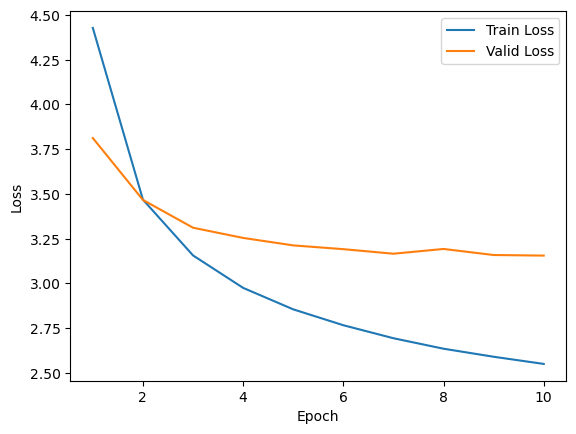

In [30]:
# Plot the training and validation losses
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [47]:
# Set the model to evaluation mode
decoderRNN.load_state_dict(torch.load("decoder_checkpoint.pth"), strict=False)
decoderRNN.eval()

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embed): Embedding(3395, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=3395, bias=True)
)

In [48]:
import random

#select 5 unique filenames in the test set
random_test_images = random.sample(test_set['file_name'].tolist(), 5)
random_test_images

['000000319492.jpg',
 '000000467109.jpg',
 '000000000192.jpg',
 '000000450620.jpg',
 '000000123028.jpg']

In [49]:
def generate_caption(image):
    # Move the image to the device
    image = image.to(device)

    # Generate captions using greedy search
    sampled_ids = decoderRNN.sample(image)

    # Convert the sampled caption IDs to words using the vocabulary
    sampled_ids = sampled_ids[0].cpu().numpy().tolist()  # shape: (max_seq_length,)
    # print(sampled_ids)
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word == "<end>" or word == "<pad>":
            break
        if word == "<unk>":
            continue
        sampled_caption.append(word)

    generated_caption = " ".join(sampled_caption)

    return generated_caption


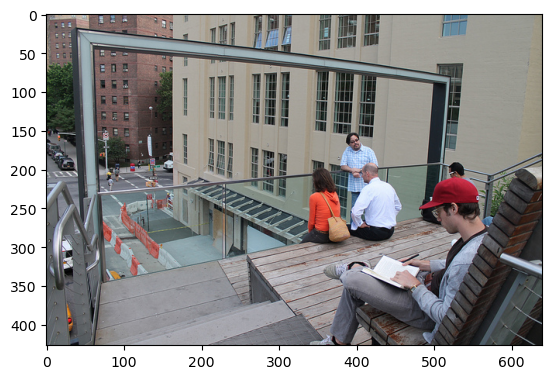

Generated Caption: a man is riding a motorcycle in the street
Reference Captions:
a group of people that are sitting on benches
a group of people sitting on top of a balcony
a young man reads a book on a wooden bench as others sit on the wooden steps outside an urban building
people sitting up on a scaffold like platform
there are people on the wooden deck over looking the street
a group of people that are sitting on benches
a group of people sitting on top of a balcony
a young man reads a book on a wooden bench as others sit on the wooden steps outside an urban building
people sitting up on a scaffold like platform
there are people on the wooden deck over looking the street


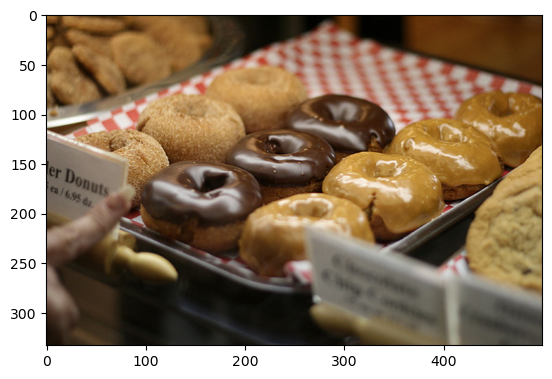

Generated Caption: three doughnuts of doughnuts are sitting on a table
Reference Captions:
person pointing to the tray of donuts behind the display window
a selection of different flavored doughnuts on a tray
a tray filled with lots of different types of donuts
a bunch of donuts that appear to be in a bakery
a bakery presents some doughnuts on their shelf


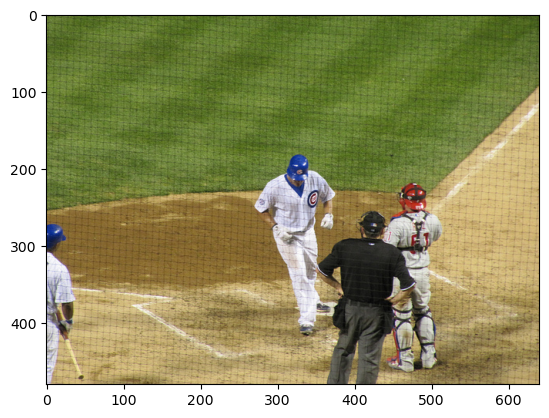

Generated Caption: a baseball player holding a bat at a baseball game
Reference Captions:
a group of baseball players is crowded at the mound
a baseball player at the area where one goes to bat
a man that is standing in the dirt near a plate
a baseball player on the home plate during a game
a baseball player for the chicago cubs stands at home plate
a group of baseball players is crowded at the mound
a baseball player at the area where one goes to bat
a man that is standing in the dirt near a plate
a baseball player on the home plate during a game
a baseball player for the chicago cubs stands at home plate


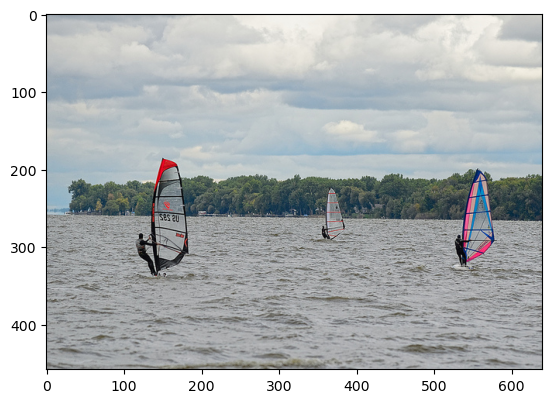

Generated Caption: a man is riding a wave on a beach
Reference Captions:
it takes a great deal of expertise to handle the sails
a group of people on surfboards with sails in the water
a couple of people are windsurfing at the beach
a picture of three people wind surfing in the ocean
the people were all out on the water with sails on their surfboards
it takes a great deal of expertise to handle the sails
a group of people on surfboards with sails in the water
a couple of people are windsurfing at the beach
a picture of three people wind surfing in the ocean
the people were all out on the water with sails on their surfboards


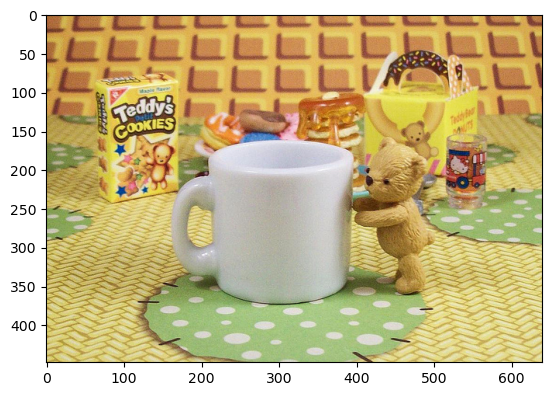

Generated Caption: a table topped with a plate of food and a bottle
Reference Captions:
a coffee mug with a toy bear leaning up against it
a cute teddy bear standing next to a coffee cup
a small teddy bear figurine is posed next to a coffee mug
a mug with a small teddy bear standing next to it and boxes of teddy s cookies
the figurines in the photo are made of toys
a coffee mug with a toy bear leaning up against it
a cute teddy bear standing next to a coffee cup
a small teddy bear figurine is posed next to a coffee mug
a mug with a small teddy bear standing next to it and boxes of teddy s cookies
the figurines in the photo are made of toys


In [50]:
for image_filename in random_test_images:
    # Preprocess the feature image
    feature=features_map[image_filename].to(device)
    feature=feature.unsqueeze(0)
    # Generate captions for the preprocessed image
    caption = generate_caption(feature)

    # Retrieve reference captions from the test set for the image
    reference_captions = test_set[test_set['file_name'] == image_filename]['clean_caption'].tolist()

    # Display the image, generated caption, and reference captions
    image = Image.open(os.path.join(IMAGE_DIR, image_filename))
    plt.imshow(np.asarray(image))
    plt.show()
    print("Generated Caption:", caption)
    print("Reference Captions:")
    for ref_caption in reference_captions:
        print(ref_caption)
    print('=================================================')


## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [106]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim'])#dict()

# Set the model to evaluation mode
decoderRNN.load_state_dict(torch.load("decoder_checkpoint.pth"))
decoderRNN.eval()

dataset_test = COCO_Features(
    df=test_set,
    vocab=vocab,
    features=features_map,
)
dataloader_test=DataLoader(dataset_test, batch_size=1, shuffle=False,collate_fn=caption_collate_fn)

# Set the model to evaluation mode
decoderRNN.load_state_dict(torch.load("decoder_checkpoint.pth"))
decoderRNN.eval()

# Create a smoothing function for BLEU score calculation
smoothing = SmoothingFunction()

# Initialize the BLEU score
bleu_score = []
refs=[]
preds=[]
# Iterate over the test dataset
for images, captions, lengths in dataloader_test:
    # Move the data to the device (e.g., GPU)
    images = images.to(device)

    # Generate captions for the images using greedy search
    sampled_ids = decoderRNN.sample(images)

    # Convert the sampled IDs to actual words
    sampled_captions = []
    for ids in sampled_ids:
        # print(ids)
        words = []
        for id in ids:
            word = vocab.idx2word[id.item()]
            if word == '<end>'or word == '<pad>' :
                break
            if word=='<unk>':
                continue
            words.append(word)
        sampled_captions.append(words)
    samled_cap=' '.join(sampled_captions[0])
    # print(samled_cap)
    preds.append(samled_cap)


    # Convert the reference captions to a list of lists
    reference_captions = []
    for caption in captions:
        ref_caption = []
        for word in caption:
            if word.item() == vocab('<pad>') or word.item() == vocab('<end>') :
                break
            if word.item() == vocab('<unk>'):
                continue
            ref_caption.append(vocab.idx2word[word.item()])
        reference_captions.append(ref_caption)
    ref_caption=' '.join(reference_captions[0])
    # print(ref_caption)
    refs.append(ref_caption)
    # break
    # Calculate the BLEU score for each sampled caption compared to the reference captions
    for sampled_caption, ref_captions in zip(sampled_captions, reference_captions):
        # choose method 3 which is suitable for short sentences
        bleu=sentence_bleu([ref_captions], sampled_caption, smoothing_function=smoothing.method3)
        # Method1:0.0588   Method3: 0.09   Method4:0.065
        bleu_score.append(bleu)

stats["ref"] = refs
stats["preds"] = preds
stats["bleu"] = bleu_score

In [107]:
stats.head()

,ref,preds,bleu,cos_sim
0,a woman wearing a is brushing her teeth,a young boy is holding a donut in his hand,0.055224,NaN
1,a man that is holding a toothbrush in his mouth,a young boy is holding a donut in his hand,0.205567,NaN
2,a closeup of a girl brushing her teeth,a young boy is holding a donut in his hand,0.049900,NaN
3,a women brushing her teeth with her tooth brush,a young boy is holding a donut in his hand,0.041961,NaN
4,a boy brushing his teeth near a window,a young boy is holding a donut in his hand,0.059342,NaN


Average BLEU score: 0.09643690921826688


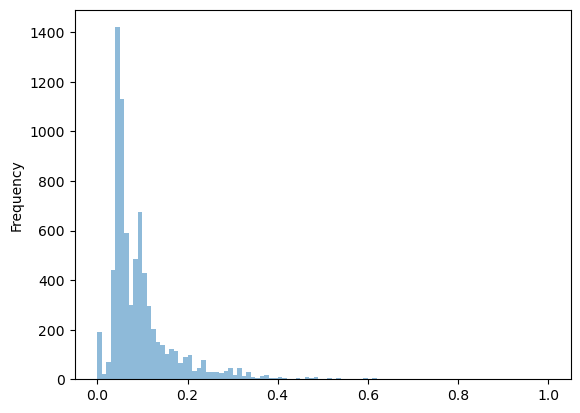

In [123]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [111]:
# TO COMPLETE
# Find the sample with the highest BLEU score
stats.sort_values(by="bleu" , inplace=True, ascending=False)
# print(stats.head(5))
preds=stats["preds"].tolist()
# print(preds)
for pred in preds:
    refs=stats[stats["preds"]==pred]["ref"].tolist()
    # print(refs)
    if len(refs) >=5:
        print('The predicted caption is: ',pred)
        print('The reference captions are: ',refs[:5])
        print('The BLEU score is: ',stats[stats["preds"]==pred]["bleu"].tolist()[0])
        break
# max_bleu = stats["bleu"].max()

The predicted caption is:  a group of zebras standing in a field
The reference captions are:  ['a group of zebras standing in a field', 'a group of zebras grazing in a field', 'a group of zebras grazing on dry grass in a large field', 'the zebras are grazing in the field together', 'a herd of zebra standing next to each other on a dry grass field']
The BLEU score is:  1.0


In [112]:
#Find the sample with the lowest BLEU score
stats.sort_values(by="bleu" , inplace=True, ascending=True)
# print(stats.head(5))
preds=stats["preds"].tolist()
for pred in preds:
    refs=stats[stats["preds"]==pred]["ref"].tolist()
    if len(refs) >= 5:
        print('The predicted caption is: ',pred)
        print('The reference captions are: ',refs[:5])
        print('The BLEU score is: ',stats[stats["preds"]==pred]["bleu"].tolist()[0])
        break

The predicted caption is:  a large boat is on the beach with a large
The reference captions are:  ['three boats in water next to pier and', 'two yellow boats and one blue one are docked', 'a body of water with three boats sitting next to each other', 'a view of boats that are outside sitting', 'three boats are reflected on shiny clear water']
The BLEU score is:  0.0


## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [120]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize an empty list to store cosine similarity scores
cos_sim_scores = []

# Iterate over the test set predictions and reference captions
for pred, ref in zip(stats['preds'], stats['ref']):
    # Split the predicted caption and reference caption into individual words
    pred_words = pred.split()
    ref_words = ref.split()
    # print('ref_words: ',ref_words)
    # print(stats[stats["preds"]==pred]["ref"].tolist()[0])
    # print('pred_words: ',pred)

    # Get the word embeddings for the predicted and reference words
    pred_embeddings = decoderRNN.embed(torch.Tensor([vocab(word) for word in pred_words]).long().to(device))
    ref_embeddings = decoderRNN.embed(torch.Tensor([vocab(word) for word in ref_words]).long().to(device))

    # Calculate the average vectors for the predicted and reference captions
    pred_avg_vector = pred_embeddings.mean(dim=0)
    ref_avg_vector = ref_embeddings.mean(dim=0)

    # Reshape the average vectors to match the input shape for cosine_similarity function
    pred_avg_vector = pred_avg_vector.reshape(1, -1).cpu().detach().numpy()
    ref_avg_vector = ref_avg_vector.reshape(1, -1).cpu().detach().numpy()

    # Calculate the cosine similarity score between the average vectors
    cos_sim = cosine_similarity(pred_avg_vector, ref_avg_vector)[0, 0]

    # Append the cosine similarity score to the list
    cos_sim_scores.append(cos_sim)
    # if len(cos_sim_scores) % 1000 == 0:
        # print(len(cos_sim_scores))

stats['cos_sim'] = cos_sim_scores

Average cosine similarity score: 0.5972336


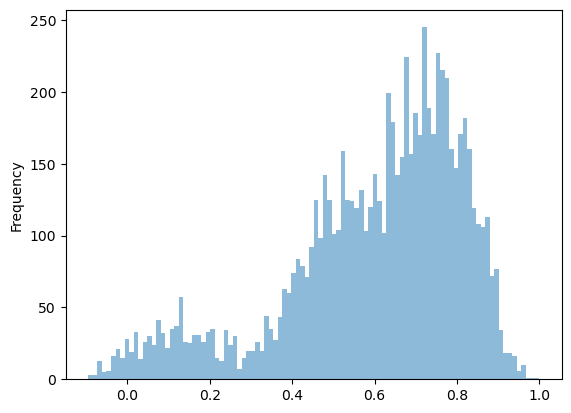

In [122]:
print("Average cosine similarity score:", stats['cos_sim'].mean())
ax = stats['cos_sim'].plot.hist(bins=100, alpha=0.5)

#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [124]:
# TO COMPLETE
# Find the sample with the highest cos_sim score
stats.sort_values(by="cos_sim" , inplace=True, ascending=False)
# print(stats.head(5))
preds=stats["preds"].tolist()
# print(preds)
for pred in preds:
    refs=stats[stats["preds"]==pred]["ref"].tolist()
    # print(refs)
    if len(refs) >=5:
        print('The predicted caption is: ',pred)
        print('The reference captions are: ',refs[:5])
        print('The cosine similarity score is: ',stats[stats["preds"]==pred]["cos_sim"].tolist()[0])
        break

The predicted caption is:  a group of zebras standing in a field
The reference captions are:  ['a group of zebras standing in a field', 'a group of zebras grazing in a field', 'a group of zebras grazing on dry grass in a large field', 'a herd of zebra standing next to each other on a dry grass field', 'the zebras are grazing in the field together']
The cosine similarity score is:  1.0


In [125]:
#Find the sample with the lowest cos_sim score
stats.sort_values(by="cos_sim" , inplace=True, ascending=True)
# print(stats.head(5))
preds=stats["preds"].tolist()
# print(preds)
for pred in preds:
    refs=stats[stats["preds"]==pred]["ref"].tolist()
    # print(refs)
    if len(refs) >=5:
        print('The predicted caption is: ',pred)

        print('The reference captions are: ',refs[:5])
        print('The cosine similarity score is: ',stats[stats["preds"]==pred]["cos_sim"].tolist()[0])
        break

The predicted caption is:  a zebra is standing in a field with a
The reference captions are:  ['two zebras are walking around their pen at the zoo', 'and zebras as in an animal safari', 'two zebras are facing in opposite directions in the picture', 'two zebras are standing next to each other', 'two zebras one standing behind the other']
The cosine similarity score is:  -0.09453174471855164


## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [126]:

cos_sim_scores = stats['cos_sim'].tolist()
cos_array = np.array(cos_sim_scores)
cos_rescale = (cos_array + 1)/2
stats['cos_rescale'] = cos_rescale
print("average cosine similarity", np.mean(cos_sim_scores))
print("average rescale cosine similarity", np.mean(cos_rescale))
print("average bleu:", np.mean(bleu_score))
stats.head(10)

average cosine similarity 0.5972336445059746
average rescale cosine similarity 0.7986168222529872
average bleu: 0.09642441415358455


,ref,preds,bleu,cos_sim,cos_rescale
3165,two zebras are walking around their pen at the...,a zebra is standing in a field with a,0.000000,-0.094532,0.452734
2973,two elephants walking through dirt near trees,a large elephant standing in the grass,0.000000,-0.093656,0.453172
1256,some metal silver equipment is lined up with,a parking meter sitting on a sidewalk near a s...,0.000000,-0.089289,0.455356
1704,pickup trucks are crossing an intersection tog...,a large truck is parked on a street,0.000000,-0.079923,0.460039
4238,the batter stands on the side of the field nea...,a baseball player is holding a bat and a baseball,0.000000,-0.078108,0.460946
2997,the elephants are walking away from the wateri...,a herd of elephants standing in a field,0.048735,-0.077219,0.461391
6203,some miniature doughnuts that are lined up tog...,a group of people sitting on a table with a la...,0.000000,-0.070991,0.464505
2982,the elephants are looking intently after their...,a elephant elephant is on a horse,0.000000,-0.070035,0.464983
3016,the elephant and sitting in the circus,a group of people playing a game of frisbee,0.000000,-0.068929,0.465535
343,bike shop inside with many also,a truck is sitting on a bench in a city,0.000000,-0.066876,0.466562


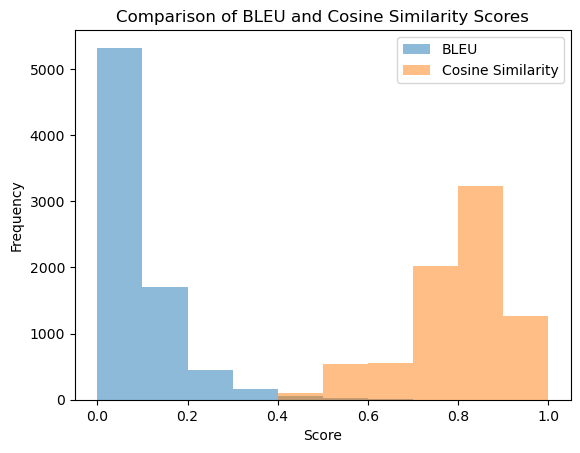

In [127]:
# plot hist of bleu and cosine similarity
plt.hist(stats['bleu'].tolist(), bins=10, range=(0, 1), alpha=0.5, label='BLEU')
plt.hist(stats['cos_rescale'].tolist(), bins=10, range=(0, 1), alpha=0.5, label='Cosine Similarity')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Comparison of BLEU and Cosine Similarity Scores')
plt.legend()
plt.show()

**Comments:**
The score of Cosine Similarity is much higher than BLEU score. But the distribution of Cosine Similarity is less concentrated than BLEU score. Therefore, we  think that BLEU has stricter judging criteria. The Cosine Similarity score is more flexible and robust, and it is more suitable for evaluating the similarity between the generated caption and the reference caption. BLEU is more suitable for evaluating the correctness and fluency of the generated caption.

***Strengths and Weaknesses of BLEU Method:***
- Strengths:
BLEU measures the n-gram overlap between the generated caption and reference captions, which provides a measure of fluency and correctness. And BLEU is relatively easy to compute and understand.
- Weaknesses:
BLEU relies solely on n-gram overlap and does not capture semantic similarity or the overall meaning of the captions.
So high scores of captions which have similar n-grams but different meanings is also possible.And if the word oder is different with similar neanings, the BLEU score will still be low.

***Strengths and Weaknesses of Cosine Similarity Method:***
- Strengths:
Cosine similarity is independent of the n-gram order, making it more flexible and robust. It measures the semantic similarity between vectors,considering the overall similarity between the generated caption and reference captions, capturing the meaning and context of the captions.
- Weaknesses:
Cosine similarity does not consider the grammatical correctness or fluency of the generated captions.
It relies on the quality of the word embeddings and may not capture subtle semantic differences.So the quality of  word embeddings will affect the cosine similarity scores.And if the predicted caption is not a complete sentence,just contains a part of word like 'a', the cosine similarity score with the reference caption will still be high.

 #### 7.2 Analysis of individual examples (10 marks)
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [128]:
# TO COMPLETE
#compare the cosine similarity score and bleu score
compared=stats.copy()
compared['cos_sim_bleu_diff'] = compared['cos_rescale'] - compared['bleu']
compared.head()

,ref,preds,bleu,cos_sim,cos_rescale,cos_sim_bleu_diff
3165,two zebras are walking around their pen at the...,a zebra is standing in a field with a,0.0,-0.094532,0.452734,0.452734
2973,two elephants walking through dirt near trees,a large elephant standing in the grass,0.0,-0.093656,0.453172,0.453172
1256,some metal silver equipment is lined up with,a parking meter sitting on a sidewalk near a s...,0.0,-0.089289,0.455356,0.455356
1704,pickup trucks are crossing an intersection tog...,a large truck is parked on a street,0.0,-0.079923,0.460039,0.460039
4238,the batter stands on the side of the field nea...,a baseball player is holding a bat and a baseball,0.0,-0.078108,0.460946,0.460946


In [131]:
#Find the sample with the difference between cos_sim and bleu score is the smallest
compared.sort_values(by="cos_sim_bleu_diff" , inplace=True, ascending=True)
preds=compared["preds"].tolist()
for pred in preds:
    refs=compared[compared["preds"]==pred]["ref"].tolist()
    print('The difference between cos_sim and bleu score is the smallest:',compared[compared["preds"]==pred]["cos_sim_bleu_diff"].tolist()[0])
    print('The predicted caption is: ',pred)
    print('The reference captions are: ',refs[:5])
    print('The cosine similarity score is: ',compared[compared["preds"]==pred]["cos_sim"].tolist()[0])
    print('The BLEU score is: ',compared[compared["preds"]==pred]["bleu"].tolist()[0])
    break

The difference between cos_sim and bleu score is the smallest: 0.0
The predicted caption is:  a group of zebras standing in a field
The reference captions are:  ['a group of zebras standing in a field', 'a group of zebras grazing in a field', 'the zebras are grazing in the field together', 'a group of zebras grazing on dry grass in a large field', 'a herd of zebra standing next to each other on a dry grass field']
The cosine similarity score is:  1.0
The BLEU score is:  1.0


In [133]:
#Find the sample with the difference between cos_sim and bleu score is the largest
compared.sort_values(by="cos_sim_bleu_diff" , inplace=True, ascending=False)
preds=compared["preds"].tolist()
for pred in preds:
    refs=compared[compared["preds"]==pred]["ref"].tolist()
    print('The difference between cos_sim and bleu score is the largest:',compared[compared["preds"]==pred]["cos_sim_bleu_diff"].tolist()[0])
    print('The predicted caption is: ',pred)
    print('The reference captions are: ',refs[:5])
    print('The cosine similarity score is: ',compared[compared["preds"]==pred]["cos_sim"].tolist()[0])
    print('The BLEU score is: ',compared[compared["preds"]==pred]["bleu"].tolist()[0])
    break

The difference between cos_sim and bleu score is the largest: 0.8859413049347217
The predicted caption is:  a bathroom with a toilet and a sink
The reference captions are:  ['a bathroom that has yellow paint and a bathtub a sink and a toilet all in white', 'a kitchen with brown cabinets a double sink and counters', 'a person in a white bathroom using a cell phone', 'a person holding a smart phone over a white toilet', 'white bathroom with a tile wall an opened a toilet and sink and a bathtub with a curtain']
The cosine similarity score is:  0.9106023907661438
The BLEU score is:  0.06935989044835018
